In [4]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pushpithathalluru","key":"980852ef272e22b8764b820d3d6abb43"}'}

In [5]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!cd ~/.kaggle/


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [6]:


!kaggle competitions download -c dogs-vs-cats



100% 810M/812M [00:23<00:00, 45.0MB/s]
100% 812M/812M [00:23<00:00, 36.3MB/s]


In [7]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

**Train sample 1000, Validation 500, Test 500:**

**• Initial Setup:**
1. Initially, a training sample of 1000, validation samples of 500, and a test of
500 samples of both cat and dog images each have been taken.
2. A convolution neural network is built with 5 layers of two-dimensional
convolutional layers with a filter size of 3 along with 4 max-pooling layers
with a pool size of 2 and connected to an output dense layer.
3. The loss function “binary cross-entropy” was used as it was a classification
model with optimizer “Adam”.

Copying Images to Train, Test and Validation Folders

In [8]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
make_subset("validation", start_index=0, end_index=500)
make_subset("test", start_index=500, end_index=1000)
make_subset("train", start_index=1000, end_index=2000)



Data Preprocessing

In [9]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Model Building

In [10]:
from tensorflow import keras
from tensorflow.keras import layers
from keras import regularizers
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32,kernel_size=3,activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128,kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256,kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

In [11]:
from keras.optimizers import Adam
model.compile(loss="binary_crossentropy",
             optimizer="adam",
              metrics=["accuracy"])

In [12]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [13]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
63/63 [==============================] - 8s 38ms/step - loss: 0.6963 - accuracy: 0.5165 - val_loss: 0.6895 - val_accuracy: 0.6120
Epoch 2/10
63/63 [==============================] - 2s 24ms/step - loss: 0.6929 - accuracy: 0.5090 - val_loss: 0.6854 - val_accuracy: 0.5960
Epoch 3/10
63/63 [==============================] - 1s 23ms/step - loss: 0.6851 - accuracy: 0.5350 - val_loss: 0.6864 - val_accuracy: 0.5330
Epoch 4/10
63/63 [==============================] - 2s 24ms/step - loss: 0.6763 - accuracy: 0.5635 - val_loss: 0.6769 - val_accuracy: 0.6010
Epoch 5/10
63/63 [==============================] - 2s 24ms/step - loss: 0.6578 - accuracy: 0.6265 - val_loss: 0.6443 - val_accuracy: 0.6340
Epoch 6/10
63/63 [==============================] - 2s 24ms/step - loss: 0.6313 - accuracy: 0.6475 - val_loss: 0.6291 - val_accuracy: 0.6530
Epoch 7/10
63/63 [==============================] - 1s 22ms/step - loss: 0.6024 - accuracy: 0.6820 - val_loss: 0.6537 - val_accuracy: 0.6540
Epoch 8/10
63

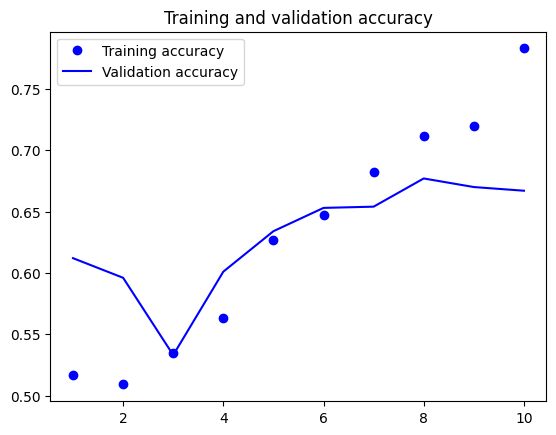

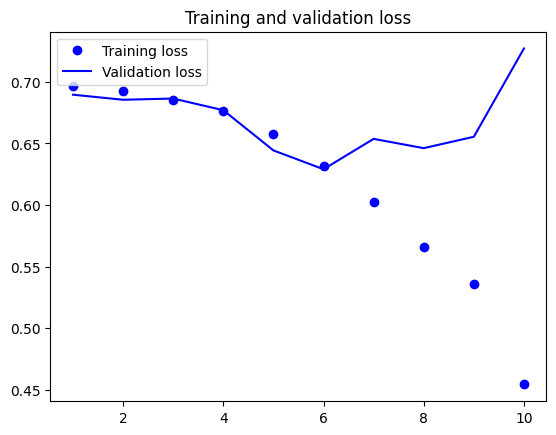

In [14]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [15]:
import matplotlib.pyplot as plt

In [16]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 10ms/step - loss: 0.6341 - accuracy: 0.6240
Test accuracy: 0.624


Test accuracy of **62.4%** and test loss of **63.4%** have been obtained.

**• Final Optimized setup:**

Below are the techniques used to optimize the model and increase its
performance,
1. Added data augmentation to input sample with flip, zoom, and rotation
parameters.
2. Added one more dense layer after flattening layer with regularizer L2 of
0.0001.
3. Added a dropout layer with a 50% dropout rate.
4. Along with optimizer Adam, a learning rate of 0.0001 is also added

Adding Data Augmentation

In [17]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.3),
        layers.RandomZoom(0.6),
    ]
)

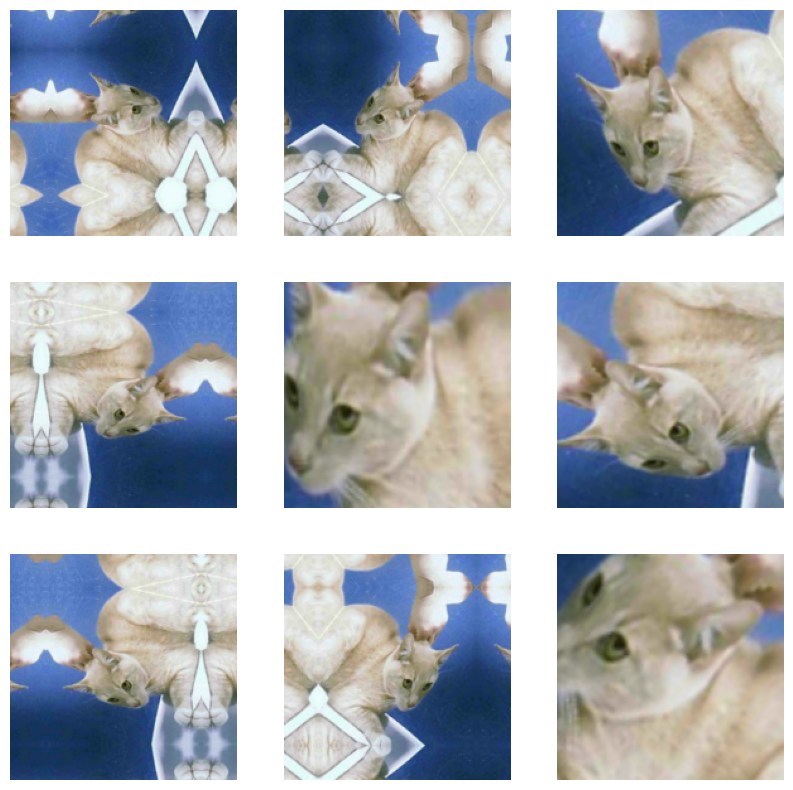

In [18]:
import warnings
warnings.filterwarnings("ignore")
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [19]:

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32,kernel_size=3,activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128,kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256,kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
#x = layers.Conv2D(filters=512,strides=2, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()
from keras.optimizers import Adam
model.compile(loss="binary_crossentropy",
             optimizer=Adam(learning_rate=0.0001),
              metrics=["accuracy"])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                      

In [20]:

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/5
63/63 [==============================] - 6s 33ms/step - loss: 0.7775 - accuracy: 0.5160 - val_loss: 0.7624 - val_accuracy: 0.5070
Epoch 2/5
63/63 [==============================] - 2s 32ms/step - loss: 0.7468 - accuracy: 0.5440 - val_loss: 0.7183 - val_accuracy: 0.6270
Epoch 3/5
63/63 [==============================] - 2s 31ms/step - loss: 0.7186 - accuracy: 0.5870 - val_loss: 0.6830 - val_accuracy: 0.6520
Epoch 4/5
63/63 [==============================] - 2s 32ms/step - loss: 0.6772 - accuracy: 0.6360 - val_loss: 0.6593 - val_accuracy: 0.6760
Epoch 5/5
63/63 [==============================] - 2s 24ms/step - loss: 0.6602 - accuracy: 0.6550 - val_loss: 0.6639 - val_accuracy: 0.6380


In [22]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")


32/32 [==============================] - 1s 10ms/step - loss: 0.6912 - accuracy: 0.6030
Test accuracy: 0.603


With the addition of these techniques, the test accuracy went up to **60.3%**, and the loss was reduced to **69.1%.**

Choosing a Random train sample size

Train sample 2000, Validation 500, Test 500:

In [23]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_1")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
make_subset("validation", start_index=0, end_index=500)
make_subset("test", start_index=500, end_index=1000)
make_subset("train", start_index=1000, end_index=3000)


In [24]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 4000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [25]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation_2000.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/5
125/125 [==============================] - 3s 24ms/step - loss: 0.6417 - accuracy: 0.6765 - val_loss: 0.6065 - val_accuracy: 0.7080
Epoch 2/5
125/125 [==============================] - 3s 25ms/step - loss: 0.5924 - accuracy: 0.7070 - val_loss: 0.5749 - val_accuracy: 0.7390
Epoch 3/5
125/125 [==============================] - 3s 25ms/step - loss: 0.5466 - accuracy: 0.7498 - val_loss: 0.5657 - val_accuracy: 0.7320
Epoch 4/5
125/125 [==============================] - 3s 21ms/step - loss: 0.5158 - accuracy: 0.7632 - val_loss: 0.5716 - val_accuracy: 0.7100
Epoch 5/5
125/125 [==============================] - 3s 25ms/step - loss: 0.4859 - accuracy: 0.7878 - val_loss: 0.5044 - val_accuracy: 0.7680


In [26]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation_2000.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 10ms/step - loss: 0.5320 - accuracy: 0.7670
Test accuracy: 0.767


The test accuracy has been increased to **76.7%**, the loss also decreased to
**53.2%.**

Train Sample: 3000

In [27]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_5")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
make_subset("validation", start_index=0, end_index=500)
make_subset("test", start_index=500, end_index=1000)
make_subset("train", start_index=2000, end_index=4000)


In [28]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 4000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [29]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation_30000.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/5
125/125 [==============================] - 3s 24ms/step - loss: 0.4892 - accuracy: 0.7797 - val_loss: 0.4676 - val_accuracy: 0.7970
Epoch 2/5
125/125 [==============================] - 3s 25ms/step - loss: 0.4415 - accuracy: 0.8110 - val_loss: 0.4657 - val_accuracy: 0.8030
Epoch 3/5
125/125 [==============================] - 3s 21ms/step - loss: 0.4118 - accuracy: 0.8267 - val_loss: 0.4873 - val_accuracy: 0.7980
Epoch 4/5
125/125 [==============================] - 3s 24ms/step - loss: 0.3715 - accuracy: 0.8497 - val_loss: 0.4536 - val_accuracy: 0.8150
Epoch 5/5
125/125 [==============================] - 3s 20ms/step - loss: 0.3356 - accuracy: 0.8660 - val_loss: 0.4740 - val_accuracy: 0.8280


In [30]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation_30000.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 10ms/step - loss: 0.4837 - accuracy: 0.7980
Test accuracy: 0.798


The test accuracy has been increased to **79.8%,** the loss also decreased to
**48.3%**. Performance has been improved significantly when there is an increase in the sample size.

Train sample 4000, Validation 500, Test 500:

In [31]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
make_subset("validation", start_index=0, end_index=500)
make_subset("test", start_index=500, end_index=1000)
make_subset("train", start_index=1000, end_index=5000)


In [32]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 8000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [33]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation_4000.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/5
250/250 [==============================] - 5s 21ms/step - loss: 0.3728 - accuracy: 0.8497 - val_loss: 0.4263 - val_accuracy: 0.8190
Epoch 2/5
250/250 [==============================] - 5s 19ms/step - loss: 0.3246 - accuracy: 0.8727 - val_loss: 0.4356 - val_accuracy: 0.8110
Epoch 3/5
250/250 [==============================] - 5s 21ms/step - loss: 0.2965 - accuracy: 0.8871 - val_loss: 0.4205 - val_accuracy: 0.8270
Epoch 4/5
250/250 [==============================] - 5s 19ms/step - loss: 0.2569 - accuracy: 0.9069 - val_loss: 0.4269 - val_accuracy: 0.8300
Epoch 5/5
250/250 [==============================] - 5s 21ms/step - loss: 0.2189 - accuracy: 0.9295 - val_loss: 0.4053 - val_accuracy: 0.8460


In [34]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation_4000.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 10ms/step - loss: 0.4489 - accuracy: 0.8250
Test accuracy: 0.825


The test accuracy has been increased to **82.5%**, also loss decreased to **44.89%.** Performance has increased significantly when there is an increase in the sample size furthermore.


**Defining Optimal Train Sample Size:**
As the training sample size increases from 1000 to 4000, from the above results it can be observed that,

*   The accuracy increased as the sample size is being increased.
*   At 3000, accuracy has increased significantly, and the loss increased along with it.
*   But at 4000, the model seems to be performing good as the accuracy increased
and test loss also decreased along with it.
*   we can observe that sample size **4000** will be the optimal sample size for the model with **82.5%** test accuracy and **44.29%** test loss.


**Use of Pre-Trained Network VGG-16:**

*   A pre-trained convolution network vgg16 has been taken for implementation of the model for a train sample size of 4000.

*   Data augmentation is done to inputs and freeze the first 4 blocks in the pre-trained vgg16 model.
*   Added a dense layer and a dropout rate of 50%.

*   Adam optimizer with a learning rate of 0.0001 was used and the model was trained with a sample size of 4000.

In [35]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))
conv_base.summary()


58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                              

In [36]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.3),
        layers.RandomZoom(0.6)
    ]
)

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
from keras.optimizers import Adam
model.compile(loss="binary_crossentropy",
             optimizer=Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [38]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="vgg16_with_data_augmentation.h5",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/5
250/250 [==============================] - 11s 44ms/step - loss: 0.2739 - accuracy: 0.8870 - val_loss: 0.0845 - val_accuracy: 0.9630
Epoch 2/5
250/250 [==============================] - 11s 45ms/step - loss: 0.2340 - accuracy: 0.9044 - val_loss: 0.0716 - val_accuracy: 0.9690
Epoch 3/5
250/250 [==============================] - 11s 43ms/step - loss: 0.2196 - accuracy: 0.9131 - val_loss: 0.0743 - val_accuracy: 0.9730
Epoch 4/5
250/250 [==============================] - 11s 43ms/step - loss: 0.1912 - accuracy: 0.9236 - val_loss: 0.0777 - val_accuracy: 0.9680
Epoch 5/5
250/250 [==============================] - 11s 44ms/step - loss: 0.1746 - accuracy: 0.9306 - val_loss: 0.0692 - val_accuracy: 0.9730


In [39]:
test_model = keras.models.load_model(
    "vgg16_with_data_augmentation.h5")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 32ms/step - loss: 0.0726 - accuracy: 0.9730
Test accuracy: 0.973


The performance of the model has been increased significantly with a test
accuracy of **97.3%** and **7.2%.**

#Conclusion

In short, picking the right training sample size and network is tricky and depends on lots of things like the data you have, the type of model you're using, and how you optimize it. Usually, having more data helps, but there's no one-size-fits-all answer. Things like tweaking how you train the model, like adding more data or adjusting settings, can make a big difference.

For our model, we found that with 4000 training samples, we got the best accuracy at 82.5% and less loss at 44.29%. Adding more samples might make the model too specific to the training data. We also tried using a pre-trained model called VGG16, which already learned a lot from big datasets. With that, we got an accuracy of 97.3% and only 7.2% loss, even with fewer samples.

Fine-tuning the pre-trained model for our specific task made it even better. Overall, finding the right balance between sample size and model choice takes some experimenting to get the best results.